In [6]:
#########1#########2#########3#########4#########5#########6#########7#########
import numpy as np
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../modules')
from skeleton_studio import Skeleton

Two images to compare: a reference and a test

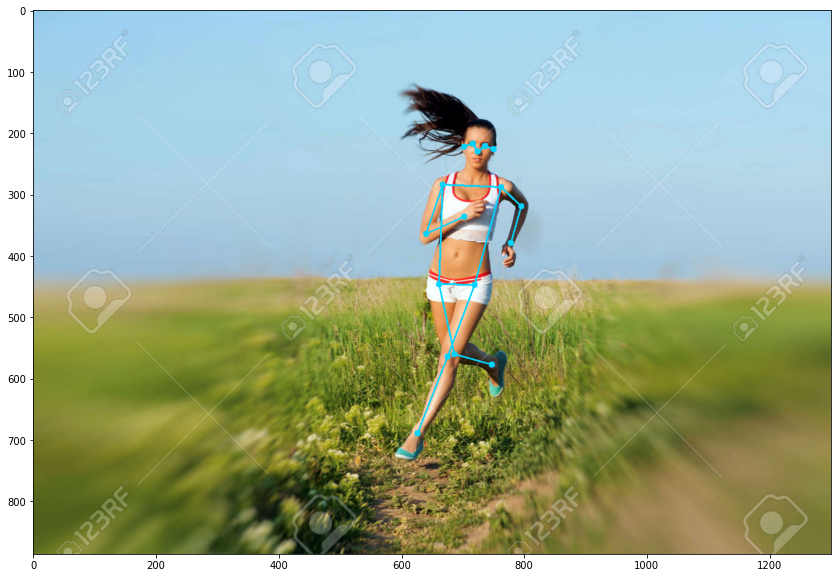

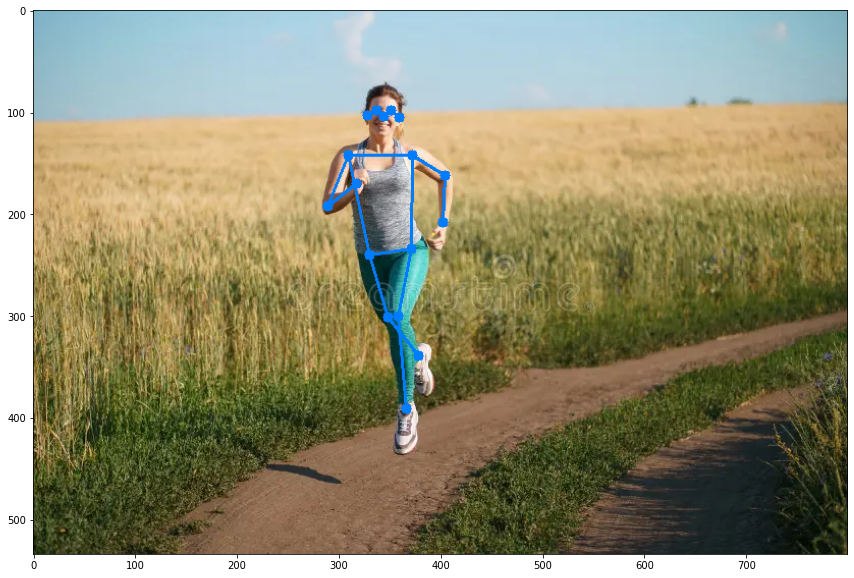

In [7]:
skeleton1, skeleton2 = Skeleton(), Skeleton()
skeleton1.inference('../images/running_girl_ref.png')
skeleton2.inference('../images/running_girl_test.webp')
skeleton1.draw()
skeleton2.draw()

Best match between skeletons via affine transformation in numpy

In [8]:
# Keypoints of the instances with the greatest confidence: [0]
keypoints_reference = skeleton1.all_keypoints[0][:, :2]
keypoints_test = skeleton2.all_keypoints[0][:, :2]

# X*A + b = Y  ->  X * A = Y
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]

# Negative keypoint scores to zero
skeleton1.all_scores[skeleton1.all_scores < 0] = 0
skeleton2.all_scores[skeleton2.all_scores < 0] = 0

# With keypoint weights
W = np.sqrt(np.diag(skeleton1.all_scores[0] * skeleton2.all_scores[0]))
X = W @ pad(keypoints_test) 
Y = W @ pad(keypoints_reference) 

# Without keypoint weights
#Y = pad(keypoints_reference)
#X = pad(keypoints_test)

# Least squares for X * A = Y
# A is the affine transformation
A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)
A[np.abs(A) < 1e-10] = 0  # low values to zero 

# Best fit of the test to the coach
transform = lambda x: unpad(pad(x) @ A)
keypoints_transformed = transform(keypoints_test)

Test skeleton best fitted to the reference image

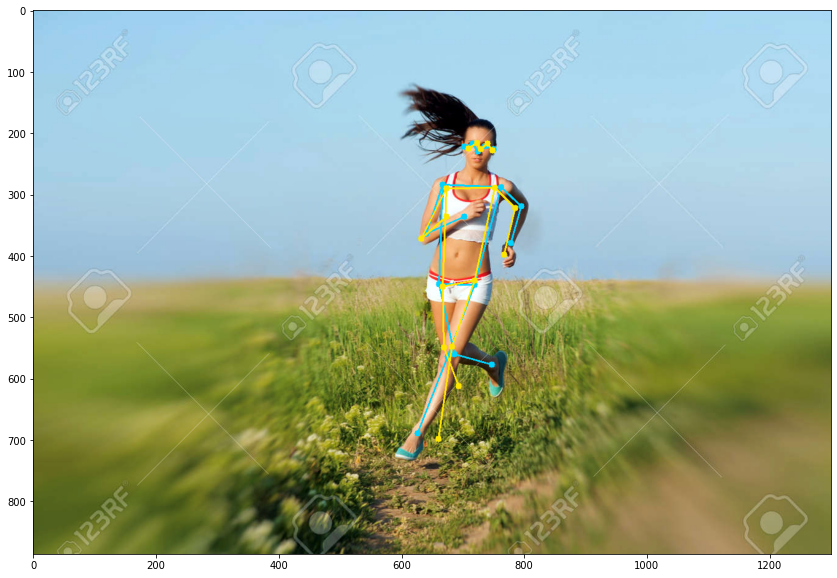

In [9]:
# Skeleton2 best fitted to the reference image
skeleton1.all_keypoints[1] = pad(keypoints_transformed)
skeleton1.all_scores[1] = skeleton2.all_scores[0]
skeleton1.confs[1] = 1

skeleton1.draw()

How the affine transormation looks like

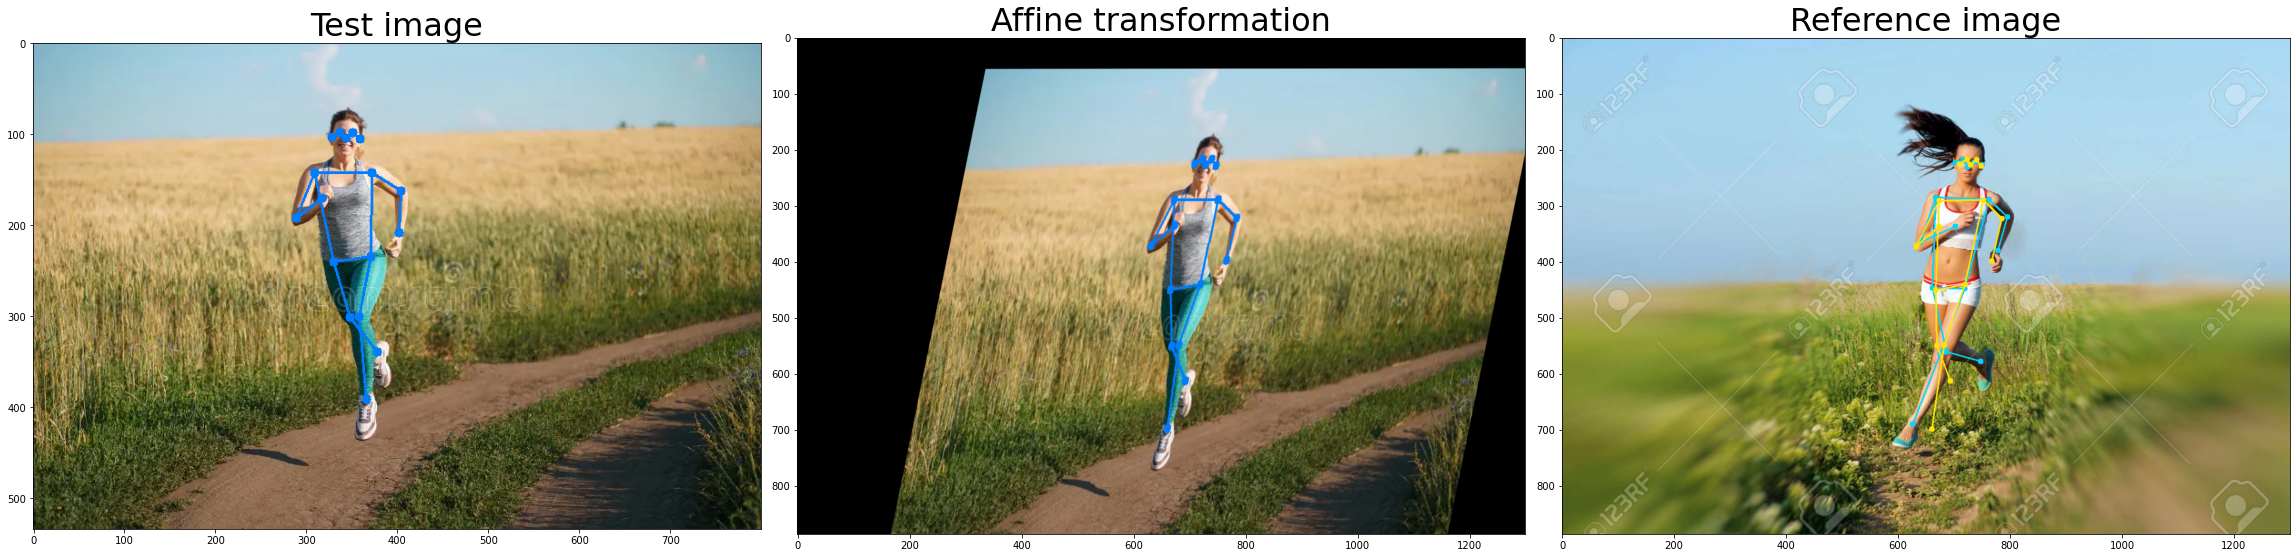

In [10]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

"""Affine transformation of the test image"""
# Tranformed image size
rows, cols = skeleton1.skeleton_img.shape[:2]

# Apply the affine transformation
img_transformed = cv2.warpAffine(
    skeleton2.skeleton_img, A[:,:2].T, (cols,rows))
 
# Display the images
fig, ax = plt.subplots(1, 3, figsize=(32, 10))
ax[0].imshow(skeleton2.skeleton_img)
ax[1].imshow(img_transformed)
ax[2].imshow(skeleton1.skeleton_img)
ax[0].set_title('Test image', fontsize=32)
ax[1].set_title('Affine transformation', fontsize=32)
ax[2].set_title('Reference image', fontsize=32)
plt.tight_layout()
plt.savefig('../images/affine_transform.png')

# Similarity

***First of all***, both cosine similarity and weighted distance ***must be calculated from centered vectors/arrays***: ${\bf F}_{\rm center} = {\bf F} - \overline{\bf F}_{x,y}$, otherwise all the figures will be ``similar'', locating in the same sector of Cartesian coordinates. By centering the arrays, we place the origin of coordibates to the center of the person's figure. The centering, obviously, must be done separately for the $x$ and $y$ coordinates. 

Cosine similarity between vectors ${\bf f}$ and ${\bf g}$ (flattened keypoint arrays): 
$$\cos(\theta) = \displaystyle\frac{{\bf f\, g}}{\lVert{\bf f}\rVert\, \lVert{\bf g}\rVert}.$$

Weighted distance $D({\bf F}, {\bf G})$ is calculated between ***normalized*** keypoint arrays ${\bf F}$ and ${\bf G}$:
$${\bf F} = \frac{\bf F}{\lVert{\bf F}\rVert},\quad {\bf G} = \frac{\bf G}{\lVert{\bf G}\rVert},$$
$$D({\bf F}, {\bf G}) = \frac{\displaystyle\sum_K c_k\,\lVert{\bf F}_k-{\bf G}_k\rVert}{\displaystyle\sum_K c_k},$$
where $c_k$ is the confidence of a k-th keypoint, ${\bf F}_k$ and ${\bf G}_k$ are its Cartesian coordinates (2-vectors).

In [6]:
center_array = lambda x, ax: x-x.mean(axis=ax) 


def cosine_similarity(pose1, pose2):
    """pose1, pose2 are [17, 2] keypoint arrays"""
    # Centering
    pose1 = center_array(pose1, 0)
    pose2 = center_array(pose2, 0)
    pose1, pose2 = pose1.flatten(), pose2.flatten()
    return pose1@pose2.T / (np.linalg.norm(pose1)*np.linalg.norm(pose2))


def weighted_distance(pose1, pose2, keypoint_confs):
    """pose1, pose2 are [17, 2] keypoint arrays 
       keypoint_confs are keypoint confidences (17-vector)"""
    
    # Centering
    pose1 = center_array(pose1, 0)
    pose2 = center_array(pose2, 0)

    # Normalization
    pose1, pose2 = pose1 / np.linalg.norm(pose1), pose2 / np.linalg.norm(pose2)
    
    # Summation of weighted distances between keypoints 
    sum = 0
    for k in range(len(pose1)):
        sum += keypoint_confs[k] * np.linalg.norm(pose1[k]-pose2[k])

    return sum / keypoint_confs.sum()

In [7]:
print(f'Cosine similarity:\
      {cosine_similarity(keypoints_transformed, keypoints_reference):.4f}')

mutual_confs = np.sqrt(skeleton1.all_scores[0] * skeleton2.all_scores[0])
print(f'Weighted distance:\
      {weighted_distance(keypoints_transformed, keypoints_reference, mutual_confs):.4f}')

Cosine similarity:      0.9902
Weighted distance:      0.0234
